
# Libraries

In [15]:
import copy
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import os
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

!pip install opencv-python
!pip install ttach
!pip install grad-cam
%matplotlib inline


Configurate hyperparameters

In [16]:
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 1e-5

# Creating dataset

In [24]:
class DetectorDataset(torch.utils.data.Dataset):
    def __init__(self, dirs, transform):
        self.images = {}
        # normal class will be displayed as 0 in results, viral as 1, covid as 2
        self.classes = ['normal', 'viral', 'covid']
        for c in self.classes:
            self.images[c] = [x for x in os.listdir(dirs[c]) if x[-3:].lower().endswith('png')]
        self.image_dirs = dirs
        self.transform = transform


    def __len__(self):
        return sum([len(self.images[c]) for c in self.classes])


    def __getitem__(self, i):
        # TODO implement Weighted Random Sampling
        c = random.choice(self.classes)
        i = i % len(self.images[c])
        image_name = self.images[c][i]
        image_path = os.path.join(self.image_dirs[c], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.classes.index(c)


# Prepare train and test datasets

In [25]:
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
image_size = (224, 224)

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=image_size),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=means, std=stds)
])
train_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/normal',
    'viral': 'COVID-19_Radiography_Dataset/viral',
    'covid': 'COVID-19_Radiography_Dataset/covid'
}
train_dataset = DetectorDataset(train_dirs, train_transform)
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=image_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=means, std=stds)
])
test_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/test/normal',
    'viral': 'COVID-19_Radiography_Dataset/test/viral',
    'covid': 'COVID-19_Radiography_Dataset/test/covid'
}
test_dataset = DetectorDataset(test_dirs, test_transform)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Creating the model

In [19]:
model = torchvision.models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(in_features=2048, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Enable GPU acceleration on Colab

In [28]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [26]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = 2 * cm.max()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Training the model

In [31]:
validate_every = 200

def evaluate_model(show_plots=False):
    model.eval()
    pred_list, true_list = [], []
    accuracy, test_loss = 0, 0

    for images, labels in dl_test:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        accuracy += sum((predictions == labels)).to(device)
        if show_plots:
            pred_list += list(predictions.cpu().numpy())
            true_list += list(labels.cpu().numpy())

    test_loss /= len(dl_test)
    accuracy = accuracy / len(test_dataset)
    if show_plots:
        print(classification_report(pred_list, true_list, digits=5))
        cm = confusion_matrix(true_list, pred_list)
        plot_confusion_matrix(cm = cm, target_names = ['normal', 'viral', 'covid'])
    model.train()
    return test_loss, accuracy

def train_model(epochs=10):
    train_losses, test_losses = [], []
    best_weights = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    for epoch in range(epochs):
        print("Starting epoch", epoch + 1, "/", epochs)
        train_loss, train_step = 0, 0
        model.train()
        for images, labels in dl_train:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels).to(device)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % validate_every == 0:
                test_loss, accuracy = evaluate_model()
                print("Validation loss:", test_loss, ", accuracy:", accuracy.item(),
                      "at step", train_step)
            train_step += 1
        # at the end of each epoch check if the model is getting better
        test_loss, accuracy = evaluate_model()
        if test_loss < best_loss:
            print("Saving new best model with validation loss", test_loss,
                  "and accuracy", accuracy.item())
            best_loss = test_loss
            best_weights = copy.deepcopy(model.state_dict())
        train_loss /= len(dl_train)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Training loss after epoch", epoch + 1, ":", train_loss)
    print("Training done")
    model.load_state_dict(best_weights)
    plt.plot(train_losses, label="Training loss")
    plt.plot(test_losses, label="Validation loss")
    plt.legend(frameon=False)
    plt.show()
    return model


# Train the model


In [28]:
%%time

model = train_model(epochs=EPOCHS)

Starting training..
Starting epoch 1/5
Evaluating at step 0
Validation Loss: 1.0892, Accuracy: 0.3983
Evaluating at step 20
Validation Loss: 0.6125, Accuracy: 0.7617
Evaluating at step 40
Validation Loss: 0.3581, Accuracy: 0.8733
Evaluating at step 60
Validation Loss: 0.2583, Accuracy: 0.8933
Evaluating at step 80
Validation Loss: 0.2058, Accuracy: 0.9217
Evaluating at step 100
Validation Loss: 0.1815, Accuracy: 0.9367
Evaluating at step 120
Validation Loss: 0.1718, Accuracy: 0.9433
Evaluating at step 140
Validation Loss: 0.1534, Accuracy: 0.9400
Evaluating at step 160
Validation Loss: 0.1506, Accuracy: 0.9350
Evaluating at step 180
Validation Loss: 0.1209, Accuracy: 0.9533
Evaluating at step 200
Validation Loss: 0.1226, Accuracy: 0.9633
Evaluating at step 220
Validation Loss: 0.1111, Accuracy: 0.9650
Evaluating at step 240
Validation Loss: 0.1029, Accuracy: 0.9783
Evaluating at step 260
Validation Loss: 0.0891, Accuracy: 0.9750
Evaluating at step 280
Validation Loss: 0.0825, Accuracy:

KeyboardInterrupt: 

# Evaluate the model

              precision    recall  f1-score   support

           0    1.00000   0.97354   0.98660       189
           1    0.98049   1.00000   0.99015       201
           2    0.99526   1.00000   0.99762       210

    accuracy                        0.99167       600
   macro avg    0.99192   0.99118   0.99146       600
weighted avg    0.99180   0.99167   0.99165       600



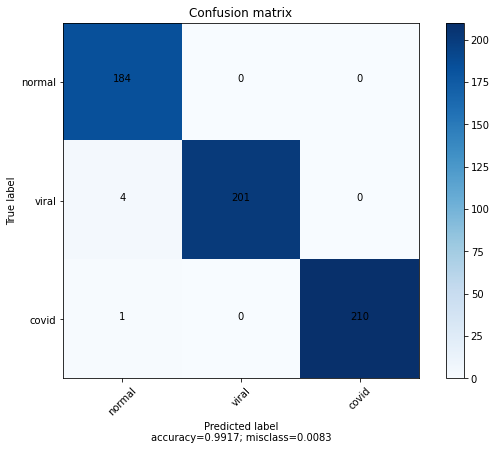

(0.020421389756895798, tensor(0.9917))

In [32]:
evaluate_model(show_plots=True)

# Save the model to be used by application

In [29]:
model.to('cpu')
torch.save(model, "resnet50_V3.pt")

# Load saved model for evaluation

In [22]:
MODEL_TO_LOAD = "resnet50_V3.pt"

model = torchvision.models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(in_features=2048, out_features=3)
model.load_state_dict(torch.load(MODEL_TO_LOAD))

<All keys matched successfully>